In [3]:
import qiskit as qk
import qinfer as qf
from qiskit.aqua.algorithms.single_sample import IQPE,QPE
from qiskit.aqua.components import iqfts
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.algorithms import ExactEigensolver
from qiskit.aqua.components.initial_states import Custom
import numpy as np
from qiskit import Aer,execute
from qiskit.aqua import QuantumInstance
# We need distributions to model priors.
from qinfer import distributions
# The noisy coin model has already been implmented, so let's import it here.
from qinfer.test_models import NoisyCoinModel
# Next, we need to import the sequential Monte Carlo updater class.
from qinfer.smc import SMCUpdater
# We'll be demonstrating approximate likelihood evaluation (ALE) as well.
from qinfer import ale
from qinfer import FiniteOutcomeModel
import matplotlib.pyplot as plt
from scipy.stats import circmean
import time
from qiskit.providers.aer import noise
from qiskit import IBMQ
IBMQ.load_account()
ibmqx_provider = IBMQ.get_provider(hub='ibm-q-wits', group='internal', project='default')

In [4]:
EPS = 1e-15
def chop(value):
    if np.abs(value) <= EPS:
        return 0
    else:
        return value

In [5]:
def radiandiff(a,b):
    FULL_ROTATION = 2 * np.pi
    return np.min(np.abs([a - b, b - a, a - b + FULL_ROTATION, b - a + FULL_ROTATION]))

In [6]:
def complexfromangle(angle):
    real = chop(np.real(np.exp(1.j * angle)))
    imag = chop(np.imag(np.exp(1.j * angle)))
    return real,imag

# IQPE on ZZ Unitary with specified phase

In [7]:
# Set-up unitary with specified phase
angle = 4 * np.pi / 5
real,imag = complexfromangle(angle)

PAULI_DICT_ZZ = {
    'paulis': [
        {"coeff": {"imag": imag, "real": real}, "label": "ZZ"}
    ]
}
QUBIT_OP_ZZ = WeightedPauliOperator.from_dict(PAULI_DICT_ZZ)
eigen_results = ExactEigensolver(QUBIT_OP_ZZ,4).run()
eigen_value = eigen_results['eigvals'][0]
eigen_vector = eigen_results['eigvecs'][0]

In [8]:
print('Eigenvalues',eigen_results['eigvals'])
print('Phase is %.4f radians' %(angle))

Eigenvalues [-0.80901699+0.58778525j -0.80901699+0.58778525j  0.80901699-0.58778525j
  0.80901699-0.58778525j]
Phase is 2.5133 radians


In [9]:
# Setup initial state as eigenvector
state_in = Custom(QUBIT_OP_ZZ.num_qubits, state_vector=eigen_vector)

In [10]:
# Use QASM Simulator for testing
simulator = Aer.get_backend('qasm_simulator')

In [11]:
# Construct IQPE circuit and simulate
iqpe_builder = IQPE(
    QUBIT_OP_ZZ,
    state_in,
    num_iterations=1,
    num_time_slices=1,
    expansion_mode='suzuki',
    expansion_order=1,
    shallow_circuit_concat=True)

# This is required to setup iqpe_builder so we can call construct_circuit() later on
iqpe_results = iqpe_circ = iqpe_builder.run(simulator,shots=1)

# QInfer Models and Definitions

In [12]:
class IQPEModel(FiniteOutcomeModel):
    
    def __init__(self):
        super(IQPEModel, self).__init__()

    ## PROPERTIES ##

    @property
    def n_modelparams(self):
        # phi
        return 1 # one for just phi, two for phi and T2

    @property
    def expparams_dtype(self):
        return [('theta','float64'), ('m','int64')]

    @property
    def is_n_outcomes_constant(self):
        return True

    ## METHODS ##

    @staticmethod
    def are_models_valid(modelparams):
        # NOTE: If T2 is included as a model parameter, restrict it to positive
        return np.logical_and(modelparams[:] >= -2*np.pi, modelparams[:]<=2*np.pi, modelparams[:] > 0).all(axis=1)

    def n_outcomes(self, expparams):
        return 2

    def likelihood(self, outcomes, modelparams, expparams):
        # We first call the superclass method, which basically
        # just makes sure that call count diagnostics are properly
        # logged.
        super(IQPEModel, self).likelihood(outcomes, modelparams, expparams)
        # Probability of getting 0 for IQPE is
        # P(0) = (1 + cos(M(theta - phi)))/2
#         pr0 = np.exp(-expparams['m'] / expparams['T2']) * (1 + np.cos(expparams['m'] * (expparams['theta'] - modelparams[:]))) / 2 + (1 - np.exp(-expparams['m'] / expparams['T2']))/2
        pr0 = (1 + np.cos(expparams['m'] * (expparams['theta'] - modelparams[:]))) / 2

        # Concatenate over outcomes.
        return FiniteOutcomeModel.pr0_to_likelihood_array(outcomes, pr0)

In [13]:
class PhaseSMCUpdater(SMCUpdater):
    @staticmethod
    def particle_mean(weights,locations):
        locs = [complexfromangle(a) for a in locations.flatten()]
        loc_x = []
        loc_y = []
        for x,y in locs:
            loc_x.append(x)
            loc_y.append(y)
        avg_x = np.average(loc_x,weights=weights)
        avg_y = np.average(loc_y,weights=weights)
        avg_angle = np.angle(avg_x + 1.j*avg_y)
        avg_mag = np.sqrt(avg_x**2 + avg_y**2)
        return avg_angle

In [14]:
# Bayesien Inference Parameters
N_PARTICLES = 5000
N_EXP = 25
USE_QISKIT_QASM_SIMULATOR = True
SIM_N_SHOTS=2048

performance_dtype = [
    ('outcome', 'i1'),
    ('est_mean', 'f8'), ('est_cov_mat', 'f8'),
    ('true_err', 'f8'), ('resample_count', 'i8'),
    ('elapsed_time', 'f8'),
    ('like_count', 'i8'), ('sim_count', 'i8'),
    ('bme', 'f8'),
    ('var', 'f8'),
    ('bme_err', 'f8')
]
performance = np.empty((N_EXP), dtype=performance_dtype)

In [15]:
# Set-up initial prior and QInfer model
# prior = distributions.UniformDistribution([0, 2 * np.pi])
prior = distributions.NormalDistribution(angle,np.pi/4)
model = IQPEModel()

In [16]:
backend_device = ibmqx_provider.get_backend('ibmq_rochester')
ideal_model = noise.device.basic_device_noise_model(
    backend_device.properties(),gate_error=False,readout_error=False,
    thermal_relaxation=False,standard_gates=True)
data_backend = Aer.get_backend('qasm_simulator')

In [41]:
# Create a Bayesian Inference Updater
updater = PhaseSMCUpdater(model, N_PARTICLES, prior,zero_weight_policy='skip')
# Set-up initial experimental parameters
THETA = prior.sample()[0][0]
M = 1
T2 = 100

posterior_marginal = []
# For each experiment we defined earlier
for idx_exp in range(N_EXP):
    print(idx_exp,'/',N_EXP)
    # Define experimental parameters
    expparams = np.array([(M,THETA)], dtype=model.expparams_dtype)
    
    # Simulate IQPE circuit and get results for inference
    circuit = iqpe_builder.construct_circuit(k=M,omega=THETA,measurement=True)
    results = execute(circuit,simulator,shots=SIM_N_SHOTS,memory=True,noise_model=ideal_model)
    counts = results.result().get_counts()
    memory = results.result().get_memory()

    # Start by simulating and recording the data. #

    # Retrieve the outcome of the simulation either from the circuit simulation or a model simulation
    if USE_QISKIT_QASM_SIMULATOR:
        outcomes = np.array([[int(m) for m in memory]])
    else:
        outcomes = model.simulate_experiment(np.array([[angle]]),expparams,repeat=SIM_N_SHOTS)
        outcomes = outcomes.reshape((1,outcomes.shape[0]))
        
    model._sim_count = 0
    model._call_count = 0

    # Time the update process
    #     tic = toc = None
    #     tic = time.time()

    # Update the posterior particles using the result of the circuit simulation
    updater.batch_update(outcomes, expparams)
    
    #     performance[idx_exp]['elapsed_time'] = time.time() - tic

    # Record the performance of this updater.
    est_mean = updater.est_mean()
    performance[idx_exp]['est_mean'] = est_mean
    performance[idx_exp]['true_err'] = radiandiff(est_mean,angle) ** 2
    performance[idx_exp]['est_cov_mat'] = updater.est_covariance_mtx()
    performance[idx_exp]['resample_count'] = updater.resample_count
    performance[idx_exp]['like_count'] = model.call_count
    performance[idx_exp]['sim_count'] = model.sim_count
    
    
    # Re-evaluate experiment parameters
    uniform_draw_01 = np.random.uniform(low=0.05,high=0.95)
#     uniform_draw_01 = np.random.uniform()
    cumsum_particles = np.cumsum(updater.particle_weights)
    draw_index = (cumsum_particles<= uniform_draw_01).argmin()
    THETA = updater.particle_locations[draw_index]
#     current_variance = updater.est_covariance_mtx()[0][0]
    
    posterior_marginal.append((updater.posterior_marginal()))

print('Inference completed')

0 / 25
1 / 25
2 / 25
3 / 25
4 / 25
5 / 25
6 / 25
7 / 25
8 / 25
9 / 25
10 / 25
11 / 25
12 / 25
13 / 25
14 / 25
15 / 25
16 / 25
17 / 25
18 / 25
19 / 25
20 / 25
21 / 25
22 / 25
23 / 25
24 / 25
Inference completed


2.5132741228718345


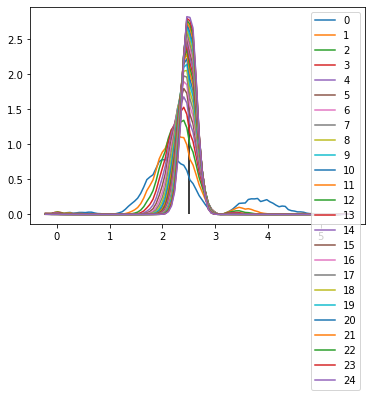

In [42]:
# Plot for each iteration
print(angle)
fig_iter = plt.figure()
ax_iter = plt.subplot(111)
for x in posterior_marginal:
#     print(x[0],x[1])
    _ = ax_iter.plot(x[0],x[1])
ax_iter.vlines(angle,ymin=0,ymax=2)
_ = ax_iter.legend([str(x) for x in range(len(posterior_marginal))])

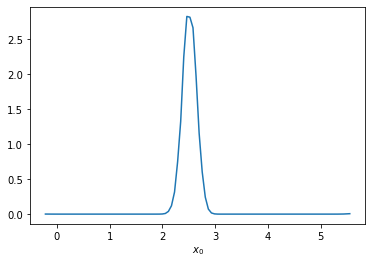

In [43]:
ax_qinfer = updater.plot_posterior_marginal(smoothing=0)

Text(0, 0.5, 'True Error')

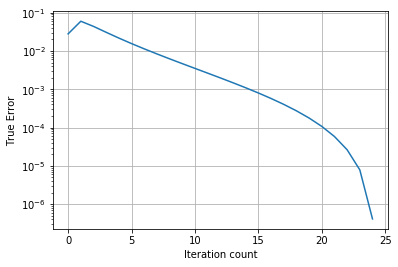

In [44]:
fig_true_err = plt.figure()
ax_true_err = plt.subplot(111)
ax_true_err.semilogy(performance['true_err'])
ax_true_err.grid()
plt.xlabel('Iteration count')
plt.ylabel('True Error')